In [1]:
pip install tf-models-official

Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Download and unzip the data. {display-mode:'form'}
#@markdown The data resides in the GitHub repository. For Hosted Runtime users, it is temporarily downloaded to the runtime's location.

from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://github.com/mtwenzel/parkinson-classification/raw/master/data/PPMI-classification.zip'
zipresp = urlopen(zipurl)
tempzip = open("PPMI-classification.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
print("download complete, extracting...")

zf = ZipFile("PPMI-classification.zip")
zf.extractall(path = 'data/')
zf.close()
print("... done")

download complete, extracting...
... done


In [3]:
zf1 = ZipFile("PPMI_SNGP_Model_with_val_Test_Data_24_07_23.zip")
zf1.extractall(path = 'sngpmodel/')
zf1.close()
print("... done")

... done


In [4]:
#@title Imports. {display-mode:'form'}
import pandas as pd
#from sklearn.metrics import confusion_matrix
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import official.nlp.modeling.layers as nlp_layers
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-19 15:19:09.843088: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-19 15:19:09.853567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-19 15:19:10.015708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-19 15:19:10.017588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 15:19:11.413898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, 109, 91)
else:
    input_shape = (109, 91, 3)

In [69]:
#@title Set the data generators. {display-mode:'form', run: "auto"}
#@markdown Data augmentation choices. Cell runs automatically if anything is changed.

data_directory = 'data/PPMI-classification/' #@param ['z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/', '/content/drive/My Drive/MEVIS/Data/PPMI-classification/'] {allow-input: true}



# Data Generator for validation without data augmentation!
test_datagen   = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(os.path.join(data_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=193,
                                                 seed = 42,
                                                 class_mode='sparse',
                                                 shuffle=True)

Found 193 images belonging to 2 classes.


In [70]:
y_train, y_test = next(test_generator)

In [71]:
from tensorflow import keras
model = keras.models.load_model('sngpmodel/PPMI_SNGP_Model_with_val_Test_Data_24_07_23/')

In [72]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)#[:, 0]

In [73]:
sngp_logits, sngp_covmat = model.predict(y_train)#, return_covmat=True)

7/7 [==============================] - 1s 55ms/step


In [74]:
sngp_covmat.shape

TensorShape([193, None])

In [75]:
dense_covmat = sngp_covmat.to_tensor()

# Compute the diagonal part of the covariance matrix
sngp_covmat = tf.linalg.matmul(dense_covmat, dense_covmat, transpose_b=True)
sngp_covmat.shape

TensorShape([193, 193])

In [76]:
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

In [77]:
print(sngp_variance.shape)

(193, 1)


In [78]:
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

In [79]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)

def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)


In [80]:
sngp_probs

<tf.Tensor: shape=(193, 2), dtype=float32, numpy=
array([[0.3200436 , 0.6799565 ],
       [0.0367638 , 0.96323615],
       [0.03709054, 0.96290946],
       [0.45388362, 0.5461164 ],
       [0.01674208, 0.98325795],
       [0.01583172, 0.98416835],
       [0.86982924, 0.13017075],
       [0.9753591 , 0.02464096],
       [0.21415314, 0.7858469 ],
       [0.6766231 , 0.32337692],
       [0.06080297, 0.939197  ],
       [0.0200289 , 0.97997105],
       [0.019078  , 0.98092204],
       [0.015978  , 0.98402196],
       [0.03331217, 0.96668786],
       [0.9662737 , 0.03372621],
       [0.30347812, 0.6965219 ],
       [0.0171495 , 0.98285043],
       [0.01530948, 0.9846905 ],
       [0.01793772, 0.9820623 ],
       [0.02998039, 0.9700196 ],
       [0.02156728, 0.9784328 ],
       [0.01898681, 0.98101324],
       [0.02609437, 0.9739057 ],
       [0.01905527, 0.98094475],
       [0.01693511, 0.98306495],
       [0.9227678 , 0.0772322 ],
       [0.01682075, 0.9831792 ],
       [0.9071462 , 0.0928

In [81]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
probabilities = sngp_probs.tolist()

In [82]:
probabilities

[[0.3200435936450958, 0.6799564957618713],
 [0.03676379844546318, 0.9632361531257629],
 [0.03709053620696068, 0.962909460067749],
 [0.4538836181163788, 0.5461164116859436],
 [0.016742082312703133, 0.9832579493522644],
 [0.01583171635866165, 0.9841683506965637],
 [0.8698292374610901, 0.13017074763774872],
 [0.9753590822219849, 0.02464095503091812],
 [0.21415314078330994, 0.7858468890190125],
 [0.6766231060028076, 0.32337692379951477],
 [0.060802966356277466, 0.9391970038414001],
 [0.02002890221774578, 0.9799710512161255],
 [0.019077999517321587, 0.9809220433235168],
 [0.015977995470166206, 0.9840219616889954],
 [0.03331216797232628, 0.9666878581047058],
 [0.9662737250328064, 0.03372621163725853],
 [0.3034781217575073, 0.6965218782424927],
 [0.017149504274129868, 0.9828504323959351],
 [0.01530948095023632, 0.9846904873847961],
 [0.017937717959284782, 0.9820622801780701],
 [0.029980389401316643, 0.9700195789337158],
 [0.02156728319823742, 0.9784327745437622],
 [0.018986806273460388, 0.981

In [83]:
y_pred = np.argmax(probabilities, axis=1)

In [84]:
y_pred

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [85]:
y_test

array([0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1.], dtype=float32)

In [86]:
acc = np.mean(y_pred == y_test)
acc

0.9222797927461139

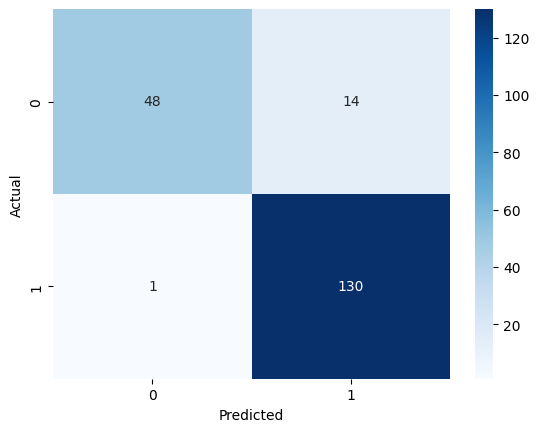

In [87]:
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix

# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Classification report:\n', classification)

Accuracy: 0.9222797927461139
Precision: 0.9027777777777778
Recall: 0.9923664122137404
F1-score: 0.9454545454545454
Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86        62
         1.0       0.90      0.99      0.95       131

    accuracy                           0.92       193
   macro avg       0.94      0.88      0.91       193
weighted avg       0.93      0.92      0.92       193



In [89]:
# calculate entropy for each row
probs_array = np.array(probabilities)
entropy = -probs_array * np.log2(probs_array)
entropy = np.sum(entropy, axis=1)

# print the first 10 entropy values
print(entropy[:10])
entropy.shape

[0.90442878 0.22725236 0.22878956 0.99385483 0.12273495 0.11734859
 0.55790629 0.16675935 0.74934664 0.90801598]


(193,)

In [90]:
#xval_batch, yval_batch = next(test_generator)

In [107]:
#FOR VALIDATION SET
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_samples = y_train.shape[0]
n_pixels = y_train.shape[1] * y_train.shape[2] * y_train.shape[3]
X = y_train.reshape(n_samples, n_pixels)

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit PCA model
pca = PCA(n_components=2)
pca.fit(X_std)

# Transform data to principal components
X_pca = pca.transform(X_std)

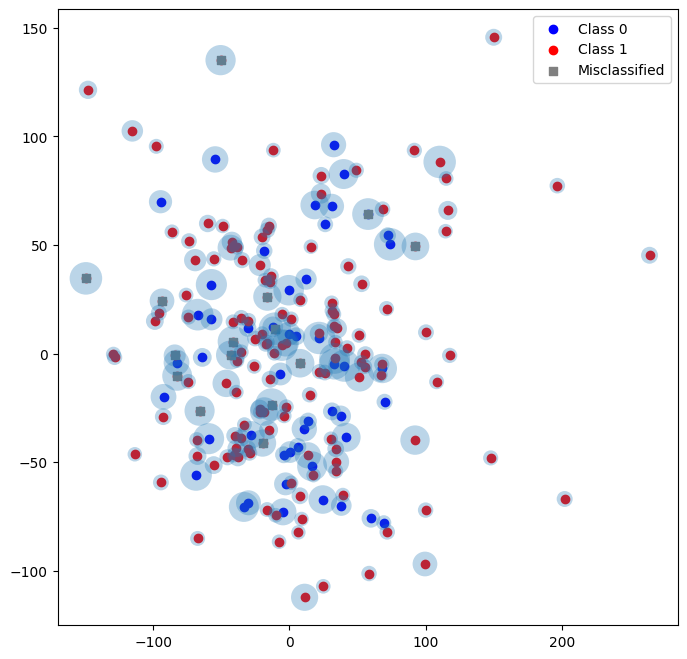

In [92]:
#@title Uncertainty Plot. {display-mode:'form', run: "auto"}
#@markdown Entropy, Predicted and True Value Plot

#@markdown Higher Entropy means higher uncertainty(INDICATED BY LARGER LIGHT BLUE MARKER AROUND THE POINTS)

transparency = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
# from sklearn.decomposition import PCA

# # Get image data and labels from val_generator
# n_samples = len(ival.filenames)
# X = np.zeros((n_samples, 109, 91, 3))
# #y_true = np.zeros(n_samples)
# for i in range(n_samples):
#     X[i] = ival[i]

# # Flatten each image into a 1D vector
# X_flat = X.reshape(n_samples, 109 * 91 * 3)

# # Apply PCA to reduce dimensionality to 2
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_flat)

# Create x and y arrays from the PCA-transformed data
x = X_pca[:, 0]
y = X_pca[:, 1]

# Create arrays for uncertainty, predicted class, and true class
#uncertainty = ...  # shape (n_samples,)
#y_pred = ...  # shape (n_samples,)
colors = ['blue', 'red']  # Color for each class

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
for c in range(2):
    mask = y_pred == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker='o', label=f'Class {c}')
ax.scatter(x[y_test != y_pred], y[y_test != y_pred], c='gray', marker='s', label='Misclassified')
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy
ax.scatter( x, y, s=sizes, alpha=transparency, edgecolors='none')

plt.show()

In [93]:
# Filter misclassified points
misclassified_mask = y_test != y_pred
entropy_misclassified = entropy[misclassified_mask]

# Print or do whatever you want with the list of entropies for misclassified points
print(entropy_misclassified)

[0.90442878 0.74934664 0.72858027 0.99948115 0.84223818 0.99761194
 0.82897835 0.66781864 0.69649885 0.94578089 0.77739258 0.53408078
 0.40446534 0.9995781  0.84937977]


In [94]:
entropy_misclassified.shape

(15,)

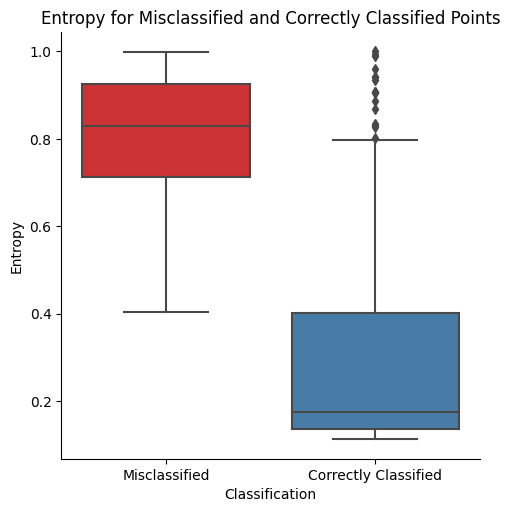

In [108]:
#3rd MODEL CATPLOT
# Compare the predictions with the true values to find correctly classified and misclassified points
correctly_classified = y_pred == y_test
misclassified = y_pred != y_test

# Create a pandas DataFrame to organize the data for the plot
data_noclass = pd.DataFrame({
    'Classification': ['Correctly Classified' if x else 'Misclassified' for x in correctly_classified],
    'Entropy': entropy
})

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_noclass, kind='box', palette='Set1')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

In [105]:
data_noclass

,Classification,Entropy
0,Misclassified,0.904429
1,Correctly Classified,0.227252
2,Correctly Classified,0.228790
3,Correctly Classified,0.993855
4,Correctly Classified,0.122735
...,...,...
188,Correctly Classified,0.112306
189,Correctly Classified,0.800695
190,Correctly Classified,0.139366
191,Correctly Classified,0.133105


In [96]:
y_test_string = np.where(y_test, "PD", "HC")
data_pd = data_noclass.copy()
data_pd['Class'] = y_test_string

In [106]:
data_pd

,Classification,Entropy,Class
0,Misclassified,0.904429,HC
1,Correctly Classified,0.227252,PD
2,Correctly Classified,0.228790,PD
3,Correctly Classified,0.993855,PD
4,Correctly Classified,0.122735,PD
...,...,...,...
188,Correctly Classified,0.112306,PD
189,Correctly Classified,0.800695,HC
190,Correctly Classified,0.139366,PD
191,Correctly Classified,0.133105,PD


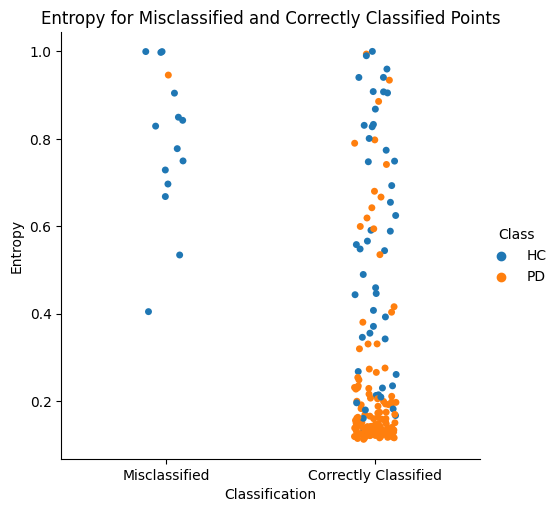

In [97]:
# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

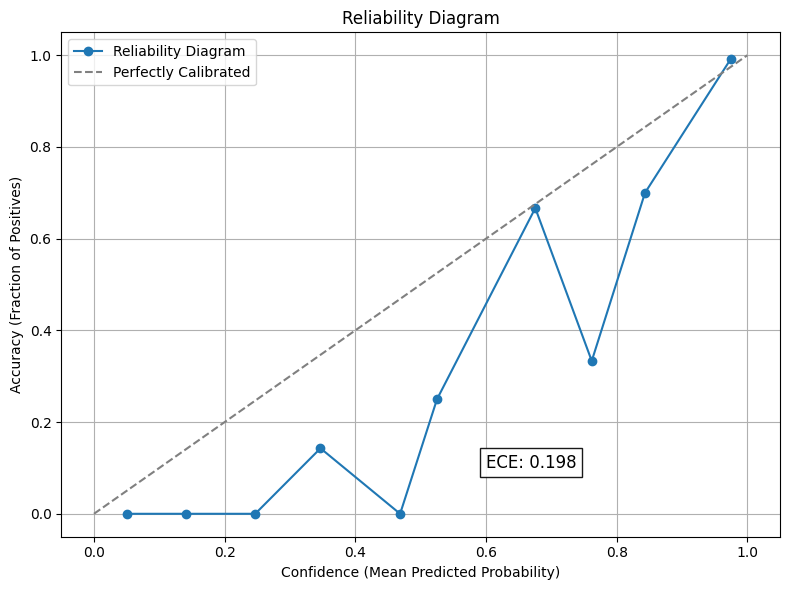

In [98]:
#SNGP RELIABILITY PLOT
from sklearn.calibration import calibration_curve
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, probs_array[:, 1], n_bins=num_bins, strategy='uniform')

# Calculate the ECE
ece_confidence = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

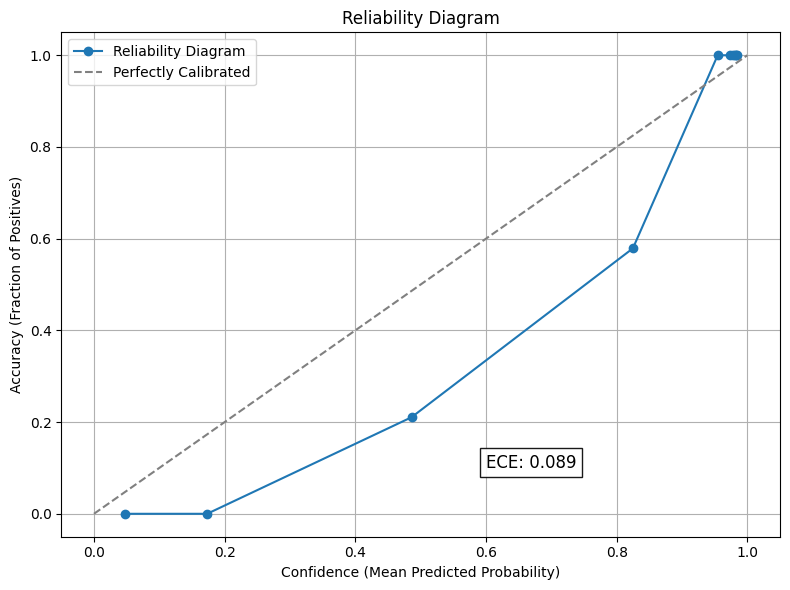

In [99]:
#SNGP RELIABILITY PLOT
from sklearn.calibration import calibration_curve
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, probs_array[:, 1], n_bins=num_bins, strategy='quantile')

# Calculate the ECE
ece_confidence = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


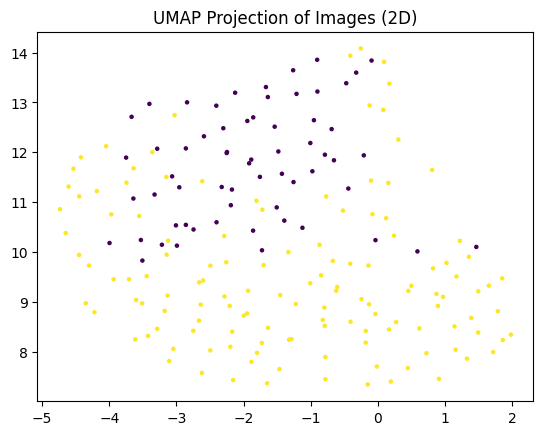

In [109]:
import umap.umap_ as umap 

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state = 42)

# Fit and transform the data
umap_result = umap_model.fit_transform(X_std)

# Visualize the 2D points
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=y_test, cmap='viridis', s=5)
plt.title("UMAP Projection of Images (2D)")
plt.show()

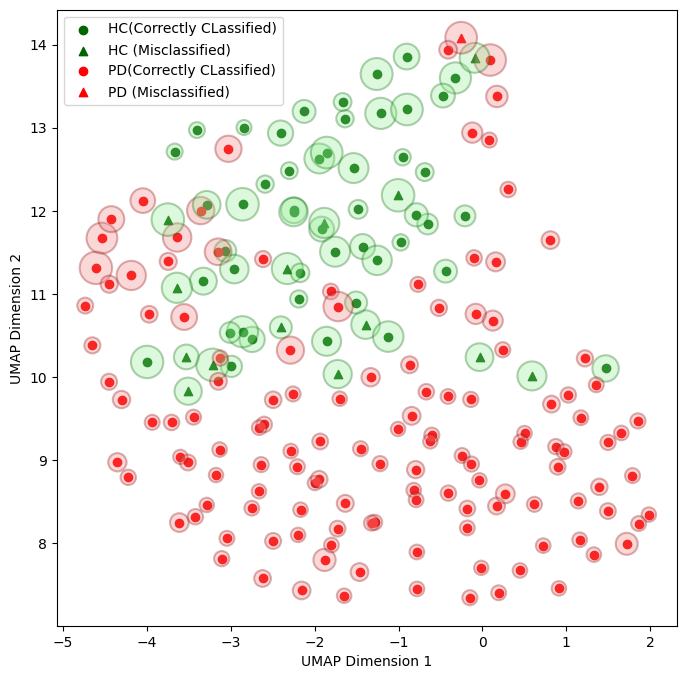

In [110]:
#BEST!!

# Create x and y arrays from the t-SNE results
x = umap_result[:, 0]
y = umap_result[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))

for c in range(2):
    mask = y_test == c  # Use ground truth labels for class mask
    
    # Correctly classified points as circles
    if c == 1:
        correct_mask = (y_test == y_pred) & (y_test == 1)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='red', label='PD(Correctly CLassified)')
    else:
        correct_mask = (y_test == y_pred) & (y_test == 0)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='darkgreen', label='HC(Correctly CLassified)')
    
    # Misclassified points as triangles
    misclassified_mask = (y_test != y_pred) & (y_test == c)
    if c == 1:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='red', label='PD (Misclassified)')
    else:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='darkgreen', label='HC (Misclassified)')

# Add legend
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy  # Modify the sizes based on uncertainty
uncertainty_colors = np.where(y_test == 1,'lightcoral', 'lightgreen')
edge_colors = np.where(y_test == 1, 'darkred', 'darkgreen')  # Use 'darkgreen' and 'darkred' for edge colors

ax.scatter(x, y, s=sizes, c=uncertainty_colors, alpha=transparency, edgecolor = edge_colors,  linewidths=1.5)
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')

plt.show()

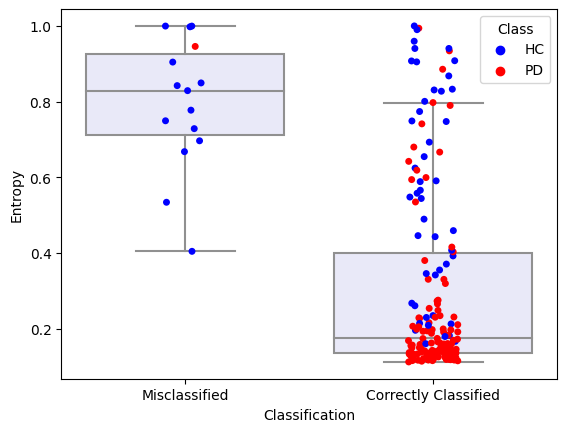

In [104]:
box_color_palette = ['#E6E6FA','#E6E6FA']# colors=[lavender, lavender]
strip_color_palette = {'HC': '#0000FF', 'PD': '#FF0000'}# colors=[bright red, bright blue]
fig, ax = plt.subplots()
ax = sns.boxplot(x='Classification', y='Entropy', data=data_noclass, palette=box_color_palette, showfliers=False)

sns.stripplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class', ax=ax, palette=strip_color_palette)
plt.show()
